In [2]:
import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import matplotlib.pyplot as plt

In [3]:
YC_COMPANIES_URL = "https://www.ycombinator.com/companies?batch=W24"
SCROLL_PAUSE_TIME = 2
STARTUP_LINK_CLASS = "_company_99gj3_339"
INFO_CARD_CLASS = "ycdc-card space-y-1.5 sm:w-[300px]"
INNER_DIV_CLASS = "flex flex-row justify-between"
FOUNDERS_SECTION_CLASS = "relative isolate z-0 border-retro-sectionBorder sm:pr-[13px] ycdcPlus:pr-0 pt-1 sm:pt-2 lg:pt-3 pb-1 sm:pb-2 lg:pb-3"
FOUNDERS_TITLE_CLASS = "text-lg font-bold"

In [4]:
def scroll_to_end(driver):
    """
    Scrolls down to load all the start ups
    """
    screen_height = driver.execute_script("return window.screen.height;")
    last_scroll_height = 0
    while True:
        driver.execute_script(f"window.scrollTo(0, {screen_height})")
        time.sleep(SCROLL_PAUSE_TIME)
        current_scroll_height = driver.execute_script("return document.body.scrollHeight;")
        if current_scroll_height == last_scroll_height:
            break
        last_scroll_height = current_scroll_height

In [5]:
def get_startup_links(driver):
    """
    Fetches links of all startups stored on the directory
    """
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup.find_all('a', class_=STARTUP_LINK_CLASS)

In [6]:
def get_inner_div_text(soup, div_class_name):
    """
    Recursively searches the specified class name inside divs
    """
    inner_text = []
    info = soup.find(class_=INFO_CARD_CLASS)
    if info:
        for div in info.find_all('div', class_=div_class_name):
            children = div.find_all(recursive=False)
            for child in children:
                if child.name == 'div' and child.has_attr('class') and child['class'][0] == div_class_name:
                    inner_text.extend(get_inner_div_text(child, div_class_name))
                elif child.name.strip() != 'br':
                    inner_text.append(child.text.strip())
    return inner_text

In [7]:
def count_founders(soup):
    """
    Counts number of founders based on the h3 elements
    """
    founders_sections = soup.find_all('section', class_=FOUNDERS_SECTION_CLASS)
    if founders_sections:
        second_section = founders_sections[1]
        return len(second_section.find_all('h3', class_=FOUNDERS_TITLE_CLASS))
    else:
        return 0

In [8]:
def scrape_startup_data(url):
    """
    Fetches detail from the startups page
    """
    response = requests.get(url)
    page = BeautifulSoup(response.content, "html.parser")
    title = page.title.get_text()
    inner_text = get_inner_div_text(page, INNER_DIV_CLASS)
    team_size = inner_text[3]
    location = inner_text[5]
    number_of_founders = count_founders(page)
    return title, team_size, location, number_of_founders

In [13]:
driver = webdriver.Chrome()

try:
    driver.get(YC_COMPANIES_URL)
    scroll_to_end(driver)

    startup_links = get_startup_links(driver)

    # Data processing and storage
    records = {}
    for link in startup_links:
        company_url = f"https://www.ycombinator.com{link.get('href')}"
        try:
            title, team_size, location, number_of_founders = scrape_startup_data(company_url)
            records[title] = [team_size, location, number_of_founders]
            print(f"{title}\nTeam Size: {team_size}, Location: {location}, Founders: {number_of_founders}\n")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {company_url}: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

finally:
    driver.quit()

Alacrity: AI Based Account Takeover Prevention Platform | Y Combinator
Team Size: 2, Location: San Francisco, Founders: 2

ParcelBio: Next-generation mRNA medicines | Y Combinator
Team Size: 2, Location: San Francisco, Founders: 2

K-Scale Labs: Open-source humanoid robots | Y Combinator
Team Size: 3, Location: New York, Founders: 0

Marr Labs: AI-voice agents that are indistinguishable from humans. | Y Combinator
Team Size: 6, Location: San Francisco, Founders: 0

Forge Rewards: The super-app for restaurant rewards | Y Combinator
Team Size: 2, Location: San Francisco, Founders: 2

FanCave: Powering the free agency of college sports | Y Combinator
Team Size: 2, Location: Roeland Park, KS, Founders: 2

RetailReady: An AI-powered supply chain compliance engine | Y Combinator
Team Size: 3, Location: , Founders: 0

Million: Make websites fast, automatically | Y Combinator
Team Size: 3, Location: San Francisco, Founders: 3

NowHouse: NowHouse is building a better Broadridge. | Y Combinator


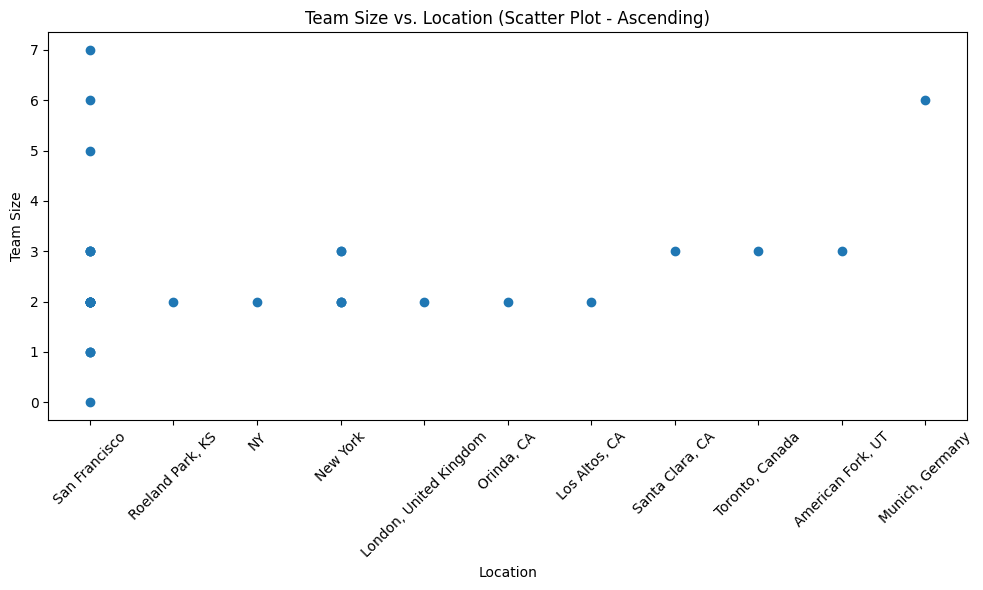

In [14]:
locations = [record[1] for record in records.values() if record[1]]  # Filter out missing locations
team_sizes = [int(record[0]) for record in records.values() if record[0]]  # Convert team size to integers

if locations and team_sizes:  # Check if data exists before plotting
    sorted_data = sorted(zip(locations, team_sizes), key=lambda x: x[1])
    sorted_locations, sorted_team_sizes = zip(*sorted_data)

    plt.figure(figsize=(10, 6))
    plt.scatter(sorted_locations, sorted_team_sizes)
    plt.xlabel("Location")
    plt.ylabel("Team Size")
    plt.title("Team Size vs. Location (Scatter Plot - Ascending)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()